<a href="https://colab.research.google.com/github/olegov99/text-classification/blob/main/NER_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install sklearn_crfsuite
!pip install -U 'scikit-learn<0.24'

     |████████████████████████████████| 743 kB 4.9 MB/s 
     |████████████████████████████████| 6.8 MB 5.2 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninstalling scikit-learn-1.0.1:
      Successfully uninstalled scikit-learn-1.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.


In [3]:
import urllib
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import io

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Exploratory Data Analysis**

In [4]:
TRAIN_DATA_URL = 'https://raw.githubusercontent.com/juand-r/entity-recognition-datasets/master/data/GUM/CONLL-format/data/train/gum-train.conll'
TEST_DATA_URL = 'https://raw.githubusercontent.com/juand-r/entity-recognition-datasets/master/data/GUM/CONLL-format/data/test/gum-test.conll'

In [5]:
COL_NAMES = ['word', 'tag']

df_train_data = pd.read_csv(TRAIN_DATA_URL, sep='\t', names=COL_NAMES, skip_blank_lines=True, encoding='utf-8', quoting=csv.QUOTE_NONE)
df_test_data = pd.read_csv(TEST_DATA_URL, sep='\t', names=COL_NAMES, skip_blank_lines=True, encoding='utf-8', quoting=csv.QUOTE_NONE)

In [6]:
df_train_data.head()

,word,tag
0,The,B-object
1,back,I-object
2,of,I-object
3,my,I-object
4,jersey,I-object


In [7]:
df_train_data.shape

(44111, 2)

In [8]:
df_train_data.isna().sum()

word    0
tag     0
dtype: int64

In [9]:
# Посмотрим на распределение тэгов

df_train_data['tag'].value_counts()

O                 20460
I-abstract         4687
I-event            2707
I-place            2212
B-abstract         2002
B-person           1920
I-person           1866
I-object           1732
B-place            1150
B-object           1017
B-event             738
I-time              663
I-organization      552
I-substance         458
B-time              401
B-organization      397
B-substance         278
I-quantity          203
I-plant             166
B-plant             144
B-animal            141
I-animal            120
B-quantity           97
Name: tag, dtype: int64

In [10]:
df_train_data['tag'].value_counts(normalize=True) * 100

O                 46.382988
I-abstract        10.625468
I-event            6.136791
I-place            5.014622
B-abstract         4.538550
B-person           4.352656
I-person           4.230237
I-object           3.926458
B-place            2.607059
B-object           2.305547
B-event            1.673052
I-time             1.503026
I-organization     1.251389
I-substance        1.038290
B-time             0.909070
B-organization     0.900002
B-substance        0.630228
I-quantity         0.460203
I-plant            0.376323
B-plant            0.326449
B-animal           0.319648
I-animal           0.272041
B-quantity         0.219900
Name: tag, dtype: float64

Тег 'O' занимает 46.38% от общего количества элементов в датасете. Тег 'I-abstract' второй по доле элементов - 10.63%. 'B-quantity' - тег с наименьшим количеством элементов (0.22%).

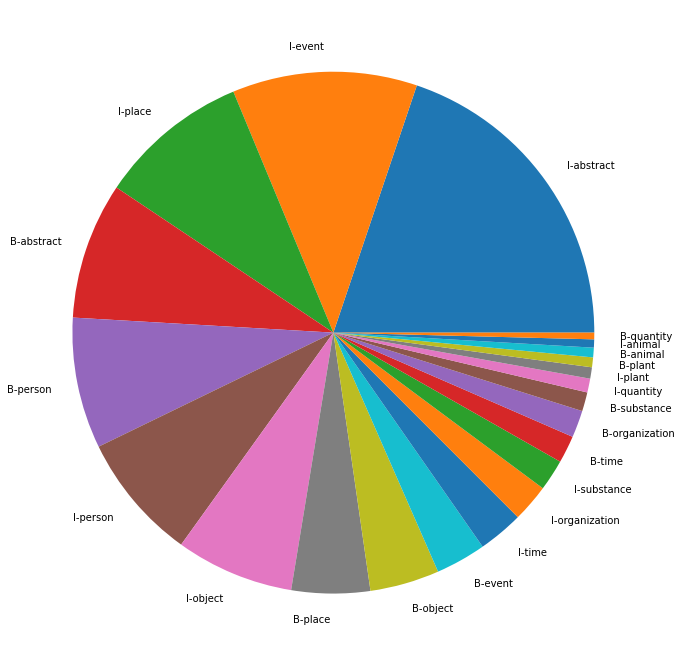

In [11]:
plt.figure(figsize=(16, 12))
plt.pie(x=df_train_data['tag'].value_counts().drop('O').values, labels=df_train_data['tag'].value_counts().drop('O').index)
plt.show()

In [12]:
vocabulary_size = len(df_train_data['word'].unique())
vocabulary_size

8060

Словарь содержит 8060 слов. Не так уж и много.

In [13]:
def get_data(file):
    content = file.readlines()
    data, sent = [], []
    for line in content:
        if not line.strip():
            if sent: data.append(sent)
            sent = []
        else:
            word, tag = line.strip().split()
            sent.append((word, tag))
    return data

def load_dataset(dataset_url):
    data = urllib.request.urlopen(dataset_url).read().decode('utf-8')
    return get_data(io.StringIO(data))

А теперь загрузим данные в виде кортежей и сгруппируем слова по предложениям.

In [14]:
train_data = load_dataset(TRAIN_DATA_URL)
test_data = load_dataset(TEST_DATA_URL)

In [15]:
train_data[0]

[('The', 'B-object'),
 ('back', 'I-object'),
 ('of', 'I-object'),
 ('my', 'I-object'),
 ('jersey', 'I-object'),
 ('says', 'O'),
 ('"', 'B-abstract'),
 ('The', 'I-abstract'),
 ('Poet', 'I-abstract'),
 ("'", 'I-abstract'),
 ('because', 'O'),
 ('growing', 'O'),
 ('up', 'O'),
 ('that', 'B-abstract'),
 ('was', 'O'),
 ('my', 'B-person'),
 ('nickname', 'O'),
 ('.', 'O')]

Сделаем небольшой препроцессинг - удалим знаки пунктуации, т.к. они не несут особого смысла.

In [16]:
import nltk
from string import punctuation

preproc_train_data = []

for item in train_data:
  removed_punctuation = [tup for tup in item if not tup[0] in punctuation]
  preproc_train_data.append(removed_punctuation)



preproc_test_data = []

for item in test_data:
  removed_punctuation = [tup for tup in item if not tup[0] in punctuation]
  preproc_test_data.append(removed_punctuation)

Самое длинное предложение имеет 71 слово. Это будет размерностью входных данных для нейронки.

In [17]:
max_seq_len = 0
for item in preproc_train_data:
  if len(item) > max_seq_len:
    max_seq_len = len(item)

max_seq_len

71

## **CRF**

Ниже приведена функция для учитывания соседних слов и позиционных тегов.

In [18]:
import sklearn_crfsuite
from sklearn.model_selection import cross_val_predict
from sklearn_crfsuite.metrics import flat_classification_report
nltk.download('averaged_perceptron_tagger')

def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    pos_tags = nltk.pos_tag([x for x,y in sent])
    return [word2features(sent, i) for i in range(len(pos_tags))]

def sent2labels(sent):
    return [label for token, label in sent]

def sent2tokens(sent):
    return [token for token, label in sent]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [19]:
X_train = [sent2features(sent) for sent in preproc_train_data]
y_train = [sent2labels(sent) for sent in preproc_train_data]

Обучим простую CRF модель. 

In [20]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=1000,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=1000)

In [21]:
X_test = [sent2features(sent) for sent in preproc_test_data]
y_test = [sent2labels(sent) for sent in preproc_test_data]

y_pred = crf.predict(X_test)
print(flat_classification_report(y_test, y_pred, labels = df_train_data['tag'].unique()))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['B-object' 'I-object' 'O' 'B-abstract' 'I-abstract' 'B-person' 'B-place'
 'I-place' 'B-organization' 'B-quantity' 'I-quantity' 'B-event' 'I-event'
 'B-substance' 'I-substance' 'B-time' 'I-time' 'I-organization' 'I-person'
 'B-plant' 'I-plant' 'B-animal' 'I-animal'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


                precision    recall  f1-score   support

      B-object       1.00      1.00      1.00       418
      I-object       1.00      1.00      1.00       757
             O       1.00      1.00      1.00      6587
    B-abstract       1.00      1.00      1.00       792
    I-abstract       1.00      1.00      1.00      1980
      B-person       1.00      1.00      1.00       823
       B-place       1.00      1.00      1.00       469
       I-place       1.00      1.00      1.00       894
B-organization       1.00      1.00      1.00       191
    B-quantity       1.00      1.00      1.00        42
    I-quantity       1.00      1.00      1.00        73
       B-event       1.00      1.00      1.00       315
       I-event       1.00      1.00      1.00       899
   B-substance       1.00      1.00      1.00        93
   I-substance       1.00      1.00      1.00       157
        B-time       1.00      1.00      1.00       179
        I-time       1.00      1.00      1.00  

Результаты выглядят слишком хорошо, что достаточно подозрительно.

## **LSTM**

In [22]:
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:   
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [23]:
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import KeyedVectors

In [24]:
MAX_LEN = 71
empty_token = '<UNK>'
empty_pos = '^'
empty_tag = '$'
pad_value = 0
embed_dim = 300

In [25]:
tags = list(set(df_train_data['tag'].values))
NUM_TAGS = len(tags)

tags2index = {t:i for i,t in enumerate(tags)}
index2tags = {i:t for i,t in enumerate(tags)}

In [26]:
sentences_train = [' '.join([tup[0].lower() for tup in sent]) for sent in preproc_train_data]
sent_tokenizer = Tokenizer(oov_token=empty_token, filters='\t\n') 
sent_tokenizer.fit_on_texts(sentences_train)
sentences_train = sent_tokenizer.texts_to_sequences(sentences_train)
sentences_train = pad_sequences(sentences_train, padding='post', value=pad_value, maxlen=MAX_LEN)
NUM_WORDS = len(sent_tokenizer.word_index)

sentences_test = [' '.join([tup[0].lower() for tup in sent]) for sent in preproc_test_data]
sentences_test = sent_tokenizer.texts_to_sequences(sentences_test)
sentences_test = pad_sequences(sentences_test, padding='post', value=pad_value, maxlen=MAX_LEN)

In [37]:
from tensorflow.keras.utils import to_categorical

tags_train = [[tags2index[tup[1]] for tup in sent] for sent in preproc_train_data]
tags_train = pad_sequences(tags_train, padding='post', value=pad_value, maxlen=MAX_LEN)

tags_test = [[tags2index[tup[1]] for tup in sent] for sent in preproc_test_data]
tags_test = pad_sequences(tags_test, padding='post', value=pad_value, maxlen=MAX_LEN)

tags_train= [to_categorical(i, num_classes = NUM_TAGS) for i in tags_train]
tags_test= [to_categorical(i, num_classes = NUM_TAGS) for i in tags_test]

In [28]:
def load_glove():
    file = f'/content/drive/My Drive/glove_models/glove.6B.{embed_dim}d.txt'
    embeddings_index = dict()
    f = open(file)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Loaded %s word vectors.' % len(embeddings_index))

    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean, emb_std = np.mean(all_embs), np.std(all_embs)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (NUM_WORDS + 1, embed_dim))
    embeddedCount = 0
    not_found = []
    for word, idx in sent_tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word.lower())
        if embedding_vector is not None: 
            embedding_matrix[idx] = embedding_vector
            embeddedCount += 1
    print('total embedded:',embeddedCount,'common words')

    del(embeddings_index)
    del(all_embs)
    return embedding_matrix

In [29]:
glove = load_glove()

Loaded 400000 word vectors.
total embedded: 6946 common words


In [64]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Bidirectional, TimeDistributed, Embedding, Concatenate

def model():
    with strategy.scope():
        custom_emb = keras.initializers.Constant(glove)
        regularizer = tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001)
        inputs = Input(shape=(MAX_LEN,), dtype='int32')
        word_emb = Embedding(NUM_WORDS + 1, embed_dim, embeddings_initializer=custom_emb, trainable=True)(inputs)
        lstm = Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=regularizer))(word_emb)
        td = TimeDistributed(Dense(NUM_TAGS, activation='softmax', kernel_regularizer=regularizer))(lstm)
        model = Model(inputs=[inputs], outputs=[td])
        return model

In [65]:
K.clear_session()
model = model()
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 71)]              0         
                                                                 
 embedding (Embedding)       (None, 71, 300)           2172300   
                                                                 
 bidirectional (Bidirectiona  (None, 71, 64)           85248     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 71, 23)           1495      
 ibuted)                                                         
                                                                 
Total params: 2,259,043
Trainable params: 2,259,043
Non-trainable params: 0
_________________________________________________________________
None


In [66]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

losses, val_losses = [], []
accs, val_accs = [], []
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['acc'])

In [67]:
history = model.fit(
    x = sentences_train,
    y = np.array(tags_train),
    validation_data = (sentences_test, np.array(tags_test)),
    epochs = 30,
    batch_size = 128 * strategy.num_replicas_in_sync,
    verbose = 1
)

losses += list(history.history['loss'])
val_losses += list(history.history['val_loss'])

accs += list(history.history['acc'])
val_accs += list(history.history['val_acc'])

Epoch 1/30
20/20 [==============================] - 14s 408ms/step - loss: 5.8246 - acc: 0.7455 - val_loss: 4.8204 - val_acc: 0.8526
Epoch 2/30
20/20 [==============================] - 7s 353ms/step - loss: 4.3938 - acc: 0.8645 - val_loss: 3.9561 - val_acc: 0.8654
Epoch 3/30
20/20 [==============================] - 7s 353ms/step - loss: 3.5835 - acc: 0.8687 - val_loss: 3.1986 - val_acc: 0.8656
Epoch 4/30
20/20 [==============================] - 7s 356ms/step - loss: 2.8766 - acc: 0.8686 - val_loss: 2.5564 - val_acc: 0.8658
Epoch 5/30
20/20 [==============================] - 7s 353ms/step - loss: 2.2938 - acc: 0.8691 - val_loss: 2.0458 - val_acc: 0.8659
Epoch 6/30
20/20 [==============================] - 7s 354ms/step - loss: 1.8479 - acc: 0.8691 - val_loss: 1.6747 - val_acc: 0.8661
Epoch 7/30
20/20 [==============================] - 7s 354ms/step - loss: 1.5346 - acc: 0.8692 - val_loss: 1.4202 - val_acc: 0.8661
Epoch 8/30
20/20 [==============================] - 7s 354ms/step - loss: 1

LSTM показывает неплохой результат - 87.99% на валидационной выборке. Посмотрим подробнее на поклассовые метрики.

In [68]:
import numpy as np
from sklearn.metrics import classification_report

results = model.predict(sentences_test)

y_pred = []
y_true = []
for i, sent in enumerate(results):
    for j, w in enumerate(sent):
        y_pred.append(index2tags[np.argmax(w)])
        y_true.append(index2tags[np.argmax(tags_test[i][j])])

y_pred = np.array(y_pred)
y_true = np.array(y_true)

print(classification_report(y_pred=y_pred, y_true=y_true, labels=df_train_data['tag'].unique()))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

      B-object       0.99      1.00      1.00     54966
      I-object       0.00      0.00      0.00        42
             O       0.00      0.00      0.00        38
    B-abstract       0.22      0.21      0.22       665
    I-abstract       0.00      0.00      0.00       191
      B-person       0.20      0.00      0.00       757
       B-place       0.30      0.36      0.33      1980
       I-place       0.00      0.00      0.00       315
B-organization       0.00      0.00      0.00       469
    B-quantity       0.00      0.00      0.00       418
    I-quantity       0.00      0.00      0.00       220
       B-event       0.00      0.00      0.00        73
       I-event       0.00      0.00      0.00       274
   B-substance       0.00      0.00      0.00        55
   I-substance       0.00      0.00      0.00       157
        B-time       0.36      0.17      0.23       823
        I-time       0.00      0.00      0.00  

Из таблицы видно, что достаточно хорошо определяется классы 'B-Object' и 'I-person'.

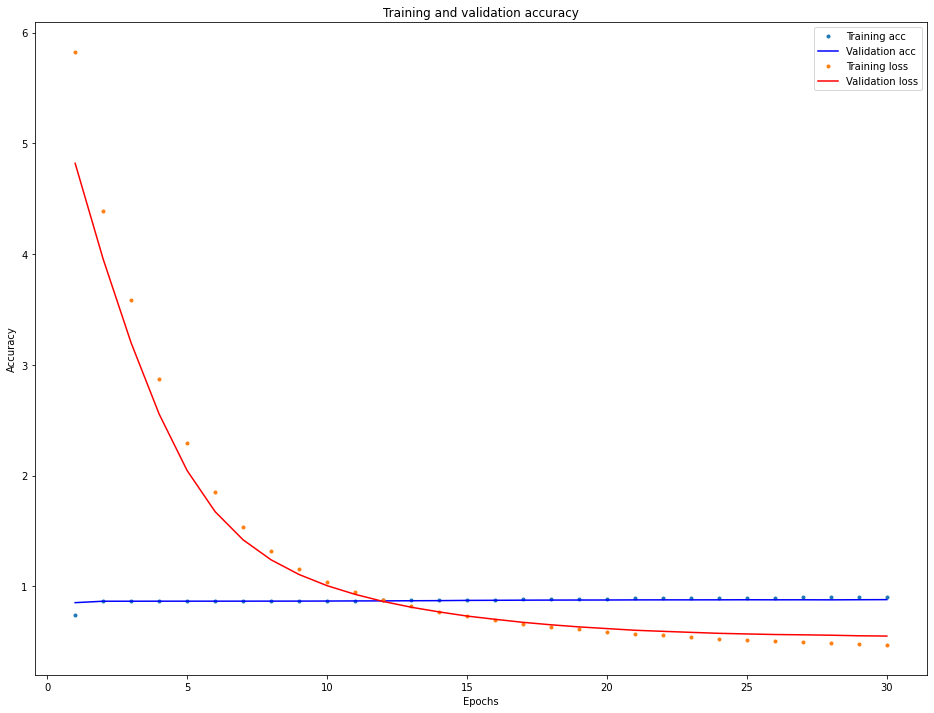

In [71]:
history_dict = history.history
history_dict.keys()
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(16, 12))
plt.clf()

plt.plot(epochs, acc, '.', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.plot(epochs, loss, '.', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

LSTM достаточно неплохо справилась с задачей, однако несбалансированность тэгов дает о себе знать. Возможно дополнительные эксперименты с различными параметрами помогут улучшить точность модели. 